In this exercise I solve a deterministic growth model using simulated data generated from an economy with parameters $\beta = 0.95$, $\alpha = 0.3$, $A = 1.0$, $\delta = 0.05$, $\gamma = 2.0$. I initiate the variables of the mathematical program at the true values, which should make the optimization easy.

  likely near In[1]:2
  likely near In[1]:2



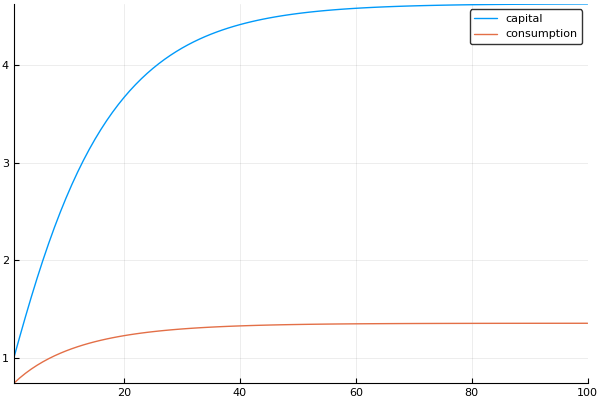

In [1]:
using CSV
using Plots; pyplot()

df = CSV.read("data.csv"; header=false, types=[Float64, Float64])
dataK = convert(Vector{Float64}, df[1])
dataC = convert(Vector{Float64}, df[2])

plot(dataK, label="capital")
plot!(dataC, label="consumption")

The economy's steady state for capital is:

In [2]:
k_stst = 4.628988089138438;

# The Mathematical Program
I define the needed function related to utility and production:

In [29]:
u_crra_prime(c, γ) = begin
    if (c <= 0)
        return -1000000.
        else
        return c^-γ
    end
end

u_crra_prime_inv(u, γ) = begin
    if (u <= 0)
        return +1000000.
    else
        return u^(-1/γ) 
    end
end

function f(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*k^α
    end
end

function f_prime(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*α*k^(α-1)
    end
end

f_prime (generic function with 1 method)

I use the Julia Mathematical Programming languange JuMP and the IpOpt solver:

In [30]:
using JuMP
using Ipopt

m = Model(solver=IpoptSolver(print_level=3, max_iter=500));

I define the deep parameters variables and give the the correct starting values:

In [31]:
@variable(m, 0 <= β <= 1, start = 0.95)
@variable(m, 0 <= δ <= 1, start = 0.05)
@variable(m, 0 <= α <= 1, start = 0.3)
@variable(m, A >= 0, start = 1)
@variable(m, γ >= 0, start = 2);

The policy function is approximated piece-wise linearly on a grid around the steady state for capital, the value at the grid points are $\theta$:

In [32]:
@variable(m, θ[1:10] >= 0, start = 0);

I define a grid on capital, $K$, with 10 nodes:

In [33]:
using BasisMatrices
params = LinParams(10, 0.2*k_stst, 2*k_stst)
basis = Basis(params)
K = nodes(basis)[1]

function interp2(x, values...) #x is the point of evaluation, values are on the grid
    params = LinParams(10, 0.2*k_stst, 2*k_stst)
    return (evalbase(params, x) * collect(values))[1]
end

interp2 (generic function with 1 method)

I define auxiliary variables for model predictions of capital and consumption:

In [34]:
@variable(m, modelCprime[i=1:10], start = 1)
@variable(m, modelKprime[i=1:10], start = 1);

I register all user-defined functions with JuMP for automatic differentiation:

In [35]:
JuMP.register(m, :interp2, 11, interp2, autodiff=true)
JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)

The auxiliary and equilibrium constraints are all defined on the grid with 10 nodes, I also impose that the policy function must be increasing:

In [36]:
@NLconstraint(m, capi_tomor[i=1:10], modelKprime[i] == f(K[i], α, A) + (1-δ)*K[i] - θ[i]) 
@NLconstraint(m, cons_tomor[i=1:10], modelCprime[i] == interp2(modelKprime[i], θ[1], θ[2], θ[3], θ[4], θ[5], θ[6],θ[7], θ[8], θ[9], θ[10]))

@NLconstraint(m, EE[i=1:10], θ[i] == u_crra_prime_inv(
    β * u_crra_prime(modelCprime[i], γ) * (f_prime(modelKprime[i], α, A) + 1-δ), γ));

@constraint(m, increasing[i=2:10], θ[i-1] <= θ[i]);

I define auxiliary expressions for the predictions of the equilibrium conditions:

In [37]:
@NLexpression(m, predictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])
@NLexpression(m, predictedC[t=1:100], interp2(dataK[t], θ[1], θ[2], θ[3], θ[4], θ[5], θ[6],θ[7], θ[8], θ[9], θ[10]));

The objective is to minimize the sum of squared errors:

In [38]:
@NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))

In [39]:
solve(m)

Total number of variables............................:       35
                     variables with only lower bounds:       12
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:       30
Total number of inequality constraints...............:        9
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        9


Number of Iterations....: 500

                                   (scaled)                 (unscaled)
Objective...............:   2.2346041001283846e-04    3.9999348031779581e-04
Dual infeasibility......:   1.2883771855368706e-01    2.3061913937029446e-01
Constraint violation....:   2.8825839670787445e-07    2.8825839670787445e-07
Complementarity.........:   1.4151354175473349e-11    2.5330882582432151e-11
Overall NLP 

:UserLimit

In [40]:
getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)

(0.9496028167619708, 0.04797644324096802, 0.29789325237867775, 0.9976185698550362, 2.1833661817454932)


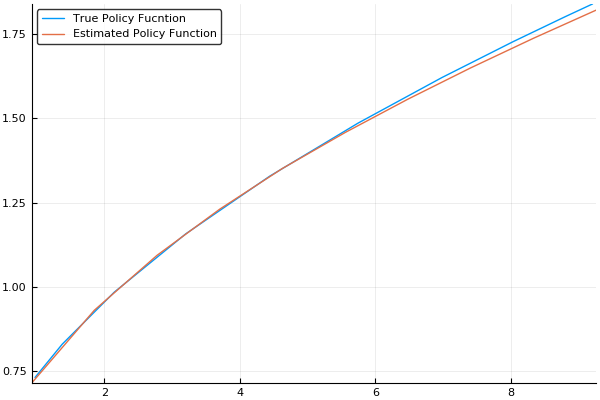

In [41]:
plot(nodes(Basis(ChebParams(10, 0.2*k_stst, 2*k_stst)))[1], [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393], label="True Policy Fucntion")
plot!(K, getvalue(θ), label="Estimated Policy Function")